In [1]:
from imports.ExtractContactCases import ExtractContactCases
from imports.TactileDataset import cases_dict

import pandas as pd
import numpy as np
import torch

from torch_geometric.data import Data
from torch_geometric.transforms import Polar
from torch_geometric.nn.pool import radius_graph, knn_graph
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_undirected
from torch_geometric.nn.pool import knn

from torch_scatter import scatter_max


from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

from torch_geometric import seed_everything
seed_everything(0)

In [2]:
import torch_scatter
from torch.nn import Sequential as Seq, Linear, ReLU, Sigmoid, BatchNorm1d
from torch.nn import Linear
from torch_cluster import fps, knn_graph


class EventConv_mean_min_max_var(MessagePassing):

    def __init__(self, in_channels, out_channels):
        super(EventConv_mean_min_max_var, self).__init__()
        self.mlp = Seq(
            Linear(out_channels, out_channels), 
            Sigmoid(), 
            Linear(out_channels, out_channels)
        )

    def forward(self, x, edge_index):
        sara = self.propagate(edge_index, x=x)
        return sara

    def aggregate(self, inputs, index):
        sums = torch_scatter.scatter_add(inputs, index, dim=0)
        maxs = torch_scatter.scatter_max(inputs, index, dim=0)[0]
        means = torch_scatter.scatter_mean(inputs, index, dim=0)
        var = torch.relu(
            torch_scatter.scatter_mean(
                inputs ** 2,
                index,
                dim=0) -
            means ** 2)

        aggrs = torch.hstack((sums, maxs, means, var))
        return self.mlp(aggrs)
    
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Linear(channels[i - 1], channels[i]),
            BatchNorm1d(channels[i]) if batch_norm else Identity(), ReLU())
        for i in range(1, len(channels))
    ])

    
class TransitionDown(torch.nn.Module):
    '''
        Samples the input point cloud by a ratio percentage to reduce
        cardinality and uses an mlp to augment features dimensionnality
    '''
    def __init__(self, in_channels, out_channels, ratio=0.25, k=16):
        super().__init__()
        self.k = k
        self.ratio = ratio
        self.mlp = MLP([in_channels, out_channels])

    def forward(self, x, pos, batch):
        # FPS sampling
        id_clusters = fps(pos, ratio=self.ratio, batch=batch)

        # compute for each cluster the k nearest points
        sub_batch = batch[id_clusters] if batch is not None else None

        # beware of self loop
        id_k_neighbor = knn(pos, pos[id_clusters], k=self.k, batch_x=batch,
                            batch_y=sub_batch)

        # transformation of features through a simple MLP
        x = self.mlp(x)

        # Max pool onto each cluster the features from knn in points
        x_out, _ = scatter_max(x[id_k_neighbor[1]], id_k_neighbor[0],
                               dim_size=id_clusters.size(0), dim=0)

        # keep only the clusters and their max-pooled features
        sub_pos, out = pos[id_clusters], x_out
        return out, sub_pos, sub_batch

In [3]:
ex = ExtractContactCases('contact_extraction1')
samples = ex.load()

In [4]:
centroids_ = pd.read_csv('centroids.csv')
cents = centroids_.values[:, :2][:, ::-1]
centroids_.head()

,centroid-0,centroid-1,label
0,50.034483,153.551724,2
1,54.471910,180.449438,3
2,55.947368,126.750000,4
3,69.600000,153.566667,5
4,69.588889,202.411111,6


In [5]:
sample_idx = list(samples.keys())
cases = [str(samples[s_idx]['case']) for s_idx in sample_idx]

train_idx, val_test_idx = train_test_split(sample_idx, test_size=1-0.6, random_state=0, stratify=cases) #fixed across extractions

cases = [str(samples[s_idx]['case']) for s_idx in val_test_idx]
val_idx, test_idx = train_test_split(val_test_idx,  test_size=0.5, random_state=0, stratify=cases) #fixed across extractions

In [6]:


def make_graph(sample, case):
    pos = torch.from_numpy(cents.copy().astype(np.float32))

    X = sample[:, :2]
    d = cdist(X, cents)

    event_node_idx = np.argmin(d, axis=-1)
    center = (120.537313, 153.835821)
    center = np.array(center)

    node_features = torch.zeros((53, 4))
    for node_idx in range(len(pos)):
        events_idx = event_node_idx == node_idx
        pos_events_idx = sample[events_idx, 3] == 1
        neg_events_idx = sample[events_idx, 3] == 0

        n_events = sum(events_idx) #1

        n_pos_events = sum(pos_events_idx) #2
        n_neg_events = n_events - n_pos_events #3

        r = np.linalg.norm(sample[events_idx, :2] - center, axis=-1) 
        r_pos = np.median(r[pos_events_idx]) if n_pos_events > 0 else 0
        r_neg = np.median(r[neg_events_idx]) if n_neg_events > 0 else 0
        delta_r = r_pos - r_neg if n_neg_events*n_pos_events > 0 else 0

        theta = np.arctan2(cents[node_idx][1] - center[1], cents[node_idx][0] - center[0]) #5

        node_features[node_idx, 0] = n_events
        node_features[node_idx, 1] = np.linalg.norm(cents[node_idx] - center) 
        node_features[node_idx, 2] = theta
        
        node_features[node_idx, 3] = delta_r
        #node_features[node_idx, 3] = delta_r
        #node_features[node_idx, 4] = theta

    edge_index = knn_graph(pos, 5)
    edge_index = to_undirected(edge_index)
    y = torch.tensor(np.array(cases_dict[case], dtype=np.float32)).reshape(1, -1).reshape(1, -1)
    data = Data(x=node_features, edge_index=edge_index, pos=pos, y=y)
    row, col = edge_index
    
    data.edge_attr = torch.stack((
        ((node_features[row, 0] - node_features[col, 0]) / node_features[:, 0].max()).abs(), #delta_n_events
        (node_features[row, 1] - node_features[col, 1]) / node_features[:, 1].max(), #delta_r,
        (node_features[row, 2] - node_features[col, 2]) / node_features[:, 2].max() #delta_theta
    )).reshape(-1, 3)
    return data

In [7]:
def train_gen():
    for sample_idx in train_idx:
        sample = np.array(samples[sample_idx]['events'])
        case = samples[sample_idx]['case']
        data = make_graph(sample, case)
        yield data
        
def val_gen():
    for sample_idx in val_idx:
        sample = np.array(samples[sample_idx]['events'])
        case = samples[sample_idx]['case']
        data = make_graph(sample, case)
        yield data
        
        
def test_gen():
    for sample_idx in test_idx:
        sample = np.array(samples[sample_idx]['events'])
        case = samples[sample_idx]['case']
        data = make_graph(sample, case)
        yield data
        



In [8]:
g2 = next(train_gen())

In [9]:
torch.load('/home/hussain/me/projects/tactile/data/legacy/contact_extraction5/train/processed/sample_1.pt')

Data(x=[1641, 1], edge_index=[2, 52512], y=[2], pos=[1641, 3], edge_attr=[52512, 3])

In [10]:
g2.edge_attr.shape

torch.Size([312, 3])

In [11]:
g2

Data(x=[53, 4], edge_index=[2, 312], y=[1, 2], pos=[53, 2], edge_attr=[312, 3])

In [12]:
td = TransitionDown(4, 4, k=5, ratio=0.5)
x, pos, _ = td(g2.x, g2.pos, None)

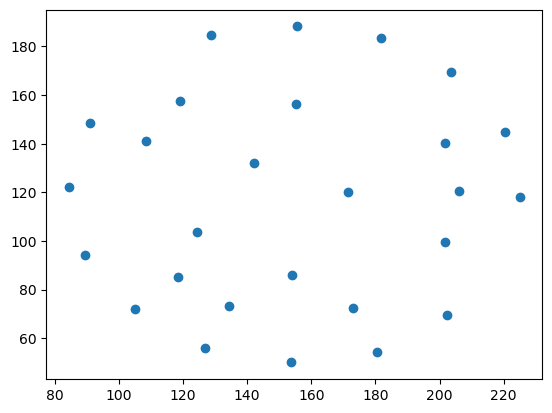

In [13]:
import matplotlib.pyplot as plt

plt.scatter(*pos.T)

##### g2.edge_attr/

In [14]:
from torch_geometric.nn import GCNConv,SplineConv,BatchNorm,global_mean_pool,global_max_pool

class spline(torch.nn.Module):
    
    def __init__(self):
        super(spline, self).__init__()
        #self.conv1 = SplineConv(3, 32, dim=3, kernel_size=3, degree=3) 
        self.conv1 = GCNConv(4, 32)
        self.bn1 = BatchNorm(32)
        
        
        self.fc1 = torch.nn.Linear(32, 16)
        self.fc2 = torch.nn.Linear(16, 2)
    
    def forward(self,data):
        data.edge_attr = data.edge_attr[:, 0]
        data.x = self.conv1(data.x, data.edge_index, edge_weight=data.edge_attr)
        data.x = torch.nn.functional.sigmoid(data.x)
        data.x = self.bn1(data.x)
        
        
        out = global_max_pool(data.x, batch=None) 
        
        out = self.fc1(out)
        out = torch.nn.functional.dropout(out, training=self.training)
        out = torch.nn.functional.sigmoid(out)
        out = self.fc2(out)
        
        return out

class edge(torch.nn.Module):
    
    def __init__(self):
        super(edge, self).__init__()
        #self.conv1 = SplineConv(3, 32, dim=3, kernel_size=3, degree=3) 
        self.edge1 = EventConv_mean_min_max_var(4, 16)
        self.conv1 = GCNConv(20, 40)
        self.bn1 = BatchNorm(40)
        
        
        self.fc1 = torch.nn.Linear(40, 20)
        self.fc2 = torch.nn.Linear(20, 2)
    
    def forward(self,data):
        data.edge_attr = data.edge_attr[:, 0].abs()
        edge_out = self.edge1(data.x, data.edge_index)
        
        #print(data.x.shape, edge_out.shape)
        
        data.x = torch.cat((edge_out, data.x), axis=-1)
        data.x = self.conv1(data.x, data.edge_index, edge_weight=data.edge_attr)
        data.x = torch.nn.functional.sigmoid(data.x)
        data.x = self.bn1(data.x)
        
        out = global_max_pool(data.x, batch=None)
        
        out = self.fc1(out)
        out = torch.nn.functional.dropout(out, training=self.training)
        out = torch.nn.functional.sigmoid(out)
        out = self.fc2(out)
        
        return out

In [15]:
model = edge().cuda()

In [16]:
loss_func = torch.nn.L1Loss()
n_epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-6, patience=25)

def validate():
    loss = 0
    for i, data in enumerate(val_gen()):      
        data = data.to('cuda')
        end_point = model(data)

        loss += loss_func(end_point, data.y).detach().item()
    loss /= len(val_idx)
    return loss

In [17]:
def test():
    loss = 0
    for i, data in enumerate(test_gen()):      
        data = data.to('cuda')
        end_point = model(data)

        loss += loss_func(end_point, data.y).detach().item()
    loss /= len(val_idx)
    return loss

In [18]:
from tqdm.auto import trange, tqdm
train_losses = []
val_losses = []
lrs = []



for epoch in trange(n_epochs, desc='training', unit='epoch'):
    
    if epoch == 10:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001
    
    if epoch == 100:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001

    if epoch == 150:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.00001
    
    
    #bunny(epoch)
    epoch_loss = 0
    lr = optimizer.param_groups[0]['lr']
    lrs.append(lr)
    val_loss = torch.inf
    with tqdm(train_gen(), unit="batch", total=len(train_idx)) as tepoch:
        for i, data in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            with torch.autograd.detect_anomaly():
                data = data.to('cuda')
                optimizer.zero_grad()
                end_point = model(data)
                loss = loss_func(end_point, data.y)
                loss.backward()
                optimizer.step()
                lr = optimizer.param_groups[0]['lr']

                epoch_loss += loss.detach().item()

                tepoch.set_postfix({
                    'train_loss': epoch_loss / (i + 1), 
                    'train_loss_degrees': epoch_loss / (i + 1) * 180/np.pi, 
                    'val_loss': val_losses[epoch - 1] if epoch > 0 else 'na',
                    'val_loss_degrees': val_losses[epoch - 1] * 180/np.pi if epoch > 0 else 'na',
                    'lr': lr
                    })

        #scheduler.step(val_loss)
        epoch_loss /= len(train_idx)
        val_loss = validate()
        tepoch.set_postfix({'train_loss': epoch_loss, 'val_loss': val_loss})
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        


training:   0%|          | 0/300 [00:00<?, ?epoch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

/tmp/ipykernel_102883/3540370543.py:31: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
/home/hussain/miniconda3/envs/tactile/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

  0%|          | 0/386 [00:00<?, ?batch/s]

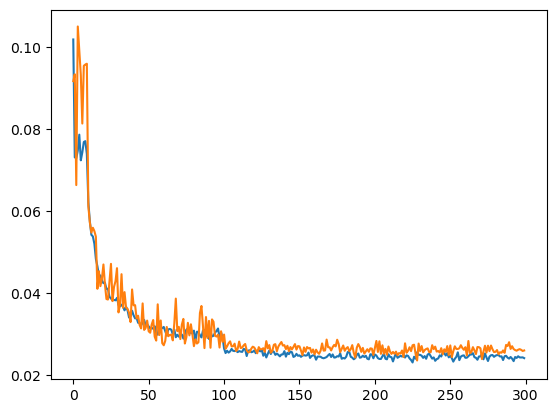

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)


In [20]:
test()

0.027133980339985025

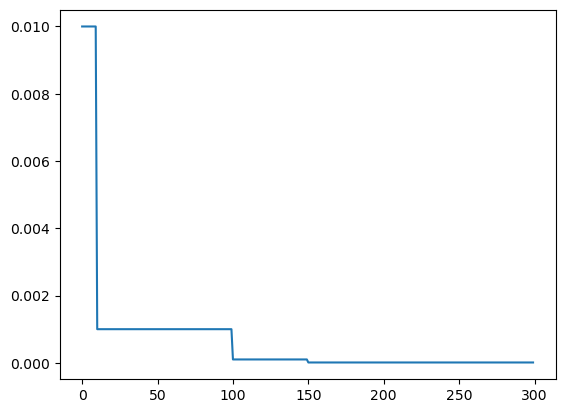

In [21]:
plt.plot(lrs)

In [22]:
model(g1.cuda())

NameError: name 'g1' is not defined